# 2122 World Population Projection

Team *They Don't Keep Me Here Cause I'm Gorgeus, They Keep Me Here Cause I'm Smart*:

Jay Kynerd, Kevin Leong, Sam Timmins

### World Population Data

With the population's doubling time shortening every year, it is no surprise the human population is expected to reach an estimated 8 billion people by next year. In a century from now, the population is projected to continue to grow, but at a slower rate. 

This journal explains Team *They Don't Keep Me Here Cause I'm Gorgeous, They Keep Me Here Cause I'm Smart*'s projection for the world population in 2122. 

### Collection of Data

First, in order to project world population, we collected past population statistics from a variety of sources (shown below). Specifically, we focused on the United Nations' and United States' statistics as we found them to be the most accurate. We also collected information on each year's birth and death rate to help calculate the percent growth of the population from year to year.

The data is parsed into a 2 DataFrames for ease of access.

In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

site = "https://en.wikipedia.org/wiki/Estimates_of_historical_world_population"
# parse all tables from Wikipedia page
# use M as decimal point to allow for numbers expressed in millions to be treated as values
tables = pd.read_html(site, header=0, index_col=0, decimal='M')

# grab table with population data from 1950 - 2016
table = tables[2]

# parse growth rate info
growth = pd.read_csv("data/growth_rate.csv", header=0, index_col=0)

# rename and remove unnecessary columns
table.columns = ["US", "PRB", "UN", "Maddison", "HYDE", "Tanton", "Biraben", "M&J", "Thomlinson", "Durand", "Clark"]
table.drop(columns=["PRB", "Maddison", "HYDE", "Tanton", "Biraben", "M&J", "Thomlinson", "Durand", "Clark"], inplace=True)

# parse birth rate and death rate data
BrDrGraph = pd.read_csv ('data/br_dr_stats.csv')

In the section above, we parse through the two tables from Wikipedia. We use pandas to read in the table and collects the population data from 1950 onwards - since that's where population data starts to become recorded. Since we are only using US and UN populaiton estimates, we also remove the columns that we don't need from the imported chart.

We also read in the birth and death rates from a CSV file also from Wikipedia. We will use this chart to project further growth rate and population.

#### Historical Population Growth

Below, we plot the table below, showing historical population growth from 1950 to the present. 

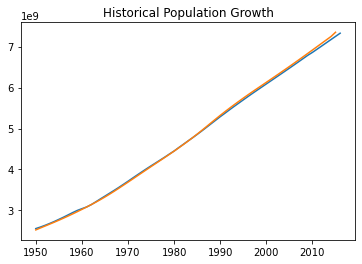

In [4]:
# plot population growth from 1950 to 2016
plt.plot(table)
plt.title("Historical Population Growth")
plt.show()

As shown above, the U.N. and US's estimates are similar and follow a general trend. They only start to diverge towards the more recent population data points.

#### Historical Birth and Death Rates

Below, we plot the birth and death rates that we collected. Like the population charts above, it starts from 1950 to 2021.

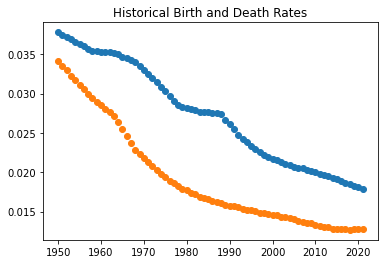

In [5]:
x = BrDrGraph["Year"]
yBR = BrDrGraph["BR"]
yDR = BrDrGraph["DR"] * 1.69

plt.scatter(x, yBR)
plt.scatter(x, yDR)
plt.title("Historical Birth and Death Rates")
plt.show()

#### Fitting Birth and Death Rate

In order to project the next century of population, we find a trend in the birth and death rate using past data. As shown below, we found that the birth and the death rate follow a sigmoid equation, so we created the sigmoid function to project the change in birth and death rate for the next century.

We plot the historical birth and death rates below.

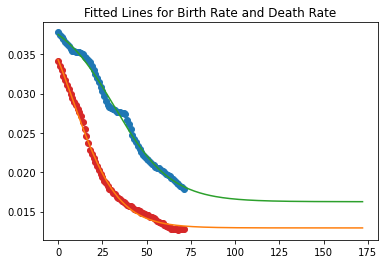

In [6]:
un = table.UN / 1e9
us = table.US / 1e9

t0 = un.index[0]
t1 = un.index[-2]
time = t1 - t0

p0 = un[t0]
p1 = un[t1]

xNorm = x - 1950

# sigmoid function
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k * (x - x0))) + b
    return (y)

# give initial data to fit function
p0BR = [max(yBR), np.median(x), 1, min(yBR)]
p0DR = [max(yDR), np.median(x), 1, min(yDR)]

# fit data to a sigmoid curve
poptBR, pcovBR = curve_fit(sigmoid, x, yBR, p0BR, method="dogbox")
poptDR, pcovDR = curve_fit(sigmoid, x, yDR, p0DR, method="dogbox")

# add years to project to series
i = 71
while x[i] != 2122: 
    x[i + 1] = x[i] + 1
    i = i + 1
   
# project birth and death rates based on sigmoid curve 
br = sigmoid(x, *poptBR)
dr = sigmoid(x, *poptDR)

plt.scatter(xNorm, yBR, color="tab:blue")
plt.plot(br, color="tab:green")
plt.scatter(xNorm, yDR, color="tab:red")
plt.plot(dr, color="tab:orange")
plt.title("Fitted Lines for Birth Rate and Death Rate")
plt.show()

From here, we can subtract the death rate from the birth rate to find the total growth rate of the population for any specific year. Then, using growth rate we predict the population for 2122.

### Projecting Population

Here, we use the equation for projected birth and death rate and use it to calculate the predicted growth rate for the next sequence of years. Then, we multiply the projected growth rate to the previous year's population in order to project the next year's population. We continue to do this until the year 2122. 

The process is shown and graphed below.

Projected population in 2122: 10.935027114004901 billion people


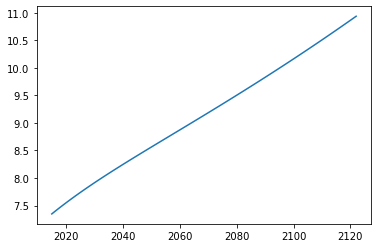

In [7]:
# project total population growth for each year from 2015 to 2122
results = {}
results[t1] = p1
for t in range(t1, 2122):
    results[t + 1] = results[t] + (results[t] * (br[t - 1950] - dr[t - 1950]))
    
s = pd.Series(results, name="Population")
s.plot()
print("Projected population in 2122: " + str(results[2122]) + " billion people")

According to the website we collected the data from, the population data has a wide variety of different accuracies. As countries submitted their total population edits, they found that some countries rounded their totals and some did not. Therefore, in order to bypass false precision, we rounded our total world population to 3 significant figures.  

In conclusion, we found that the world population in 2122 will be approximately:

### 10.9 Billion People